In [34]:
from __future__ import division, print_function
import numpy as np
from astropy.modeling import models
from astropy import coordinates as coord
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['image.origin'] = 'lower'
x, y = np.mgrid[:1000, :1000]

### Imaging Example

In [35]:
import tools
from gwcs import wcs


In [36]:
# Read a pixel to sky transform from a file and create the
# WCS object using the default "input_frame='detector'"

transform = tools.read_model('pix2sky.asdf')
gw = wcs.WCS(output_frame='icrs', forward_transform=transform)
print(gw)


  From   Transform
-------- ---------
detector   pix2sky
    icrs      None


In [37]:
# Call the WCS object as a function
# to perform the forward transform

ra, dec = gw(1, 2)
print(ra, dec)


5.6305262191 -72.0545768649


In [38]:
gw.invert(ra, dec)

(1.0001954633661871, 2.000000000806444)

In [39]:
# Using frame objects allows to connect it with astropy.coordinates
from gwcs import coordinate_frames as cf
detector = cf.DetectorFrame()
focal = cf.FocalPlaneFrame()
sky = cf.CelestialFrame(reference_frame=coord.ICRS(), axes_order=(0, 1))

distortion = tools.read_model('dist.asdf')
focal2sky = tools.read_model('foc2sky.asdf')

pipeline = [(detector, distortion),
            (focal, focal2sky),
            (sky, None)]

imwcs = wcs.WCS(output_frame=sky, forward_transform=pipeline)
print(imwcs)

    From    Transform 
----------- ----------
   detector distortion
focal_plane    foc2sky
       icrs       None


In [40]:
# The frames available within a pipeline a stored in a dict 

imwcs.available_frames

{u'detector': <DetectorFrame(axes_order=(0, 1), name=detector, reference_position=Local,         axes_names=[u'x', u'y'],
 u'focal_plane': <FocalPlaneFrame(2, axes_order=(0, 1), reference_frame=<Focal Frame>, reference_positionLocal,unit=[Unit("pix"), Unit("pix")], axes_names=[u'x', u'y'], name=focal_plane)>,
 'icrs': <CelestialFrame(reference_frame=<ICRS Frame>, axes_order=(0, 1), reference_position=Barycenter,         unit=[Unit("deg"), Unit("deg")], name=icrs)>}

In [41]:
ra, dec = imwcs(1, 2)
print(ra, dec)

5.63030044041 -72.0544788707


In [42]:
# The `world_coordinates` method creates an 
# astropy.coordinates.SkyCoordinate object
sky = imwcs.output_frame.world_coordinates(ra, dec)
print(sky)
print(sky.galactic)
    

<SkyCoord (ICRS): (ra, dec) in deg
    (5.63030044, -72.05447887)>
<SkyCoord (Galactic): (l, b) in deg
    (306.06953967, -44.89719105)>


In [43]:
# Retrieve a subtransform
distortion = imwcs.get_transform(detector, focal)
print(distortion(1, 2))


(-0.5343708149195018, -6.35901904497471)


In [44]:

shift = models.Shift(0.01) & models.Shift(0.02)

imwcs.insert_transform(frame='focal_plane', transform=shift, after=False)

In [45]:
imwcs.get_transform(detector, focal)(1,2)


(-0.5243708149195018, -6.339019044974711)

### IFU example

In [46]:
from gwcs import selector
miri_mask = tools.miri_mask()
detector_mask = selector.SelectorMask(miri_mask)
print(detector_mask.__class__)

<class 'gwcs.selector.SelectorMask'>
Name: SelectorMask
Inputs: (u'x', u'y')
Outputs: z


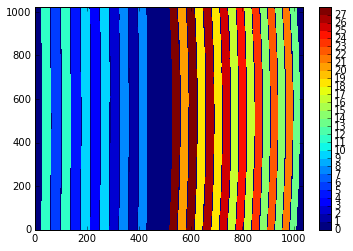

In [47]:
tools.show(detector_mask.mask, 28)

In [54]:
# miri_models is a dict {slice_# : transform}

miri_models = tools.miri_models()

miri_selector = selector.RegionsSelector(inputs=('x', 'y'),
                                         outputs=('alpha', 'beta', 'lam'), 
                                         selector=miri_models,
                                         mask=detector_mask)

In [49]:
from gwcs import spectral_builtin_frames

sky = cf.CelestialFrame(coord.ICRS())
spec = cf.SpectralFrame(spectral_builtin_frames.Wavelength())
oframe = cf.CompositeFrame([sky, spec])

ifuwcs = wcs.WCS(output_frame=oframe, forward_transform=miri_selector)

x, y = np.mgrid[:1024, :1032]
alpha, beta, lam = ifuwcs(x, y)


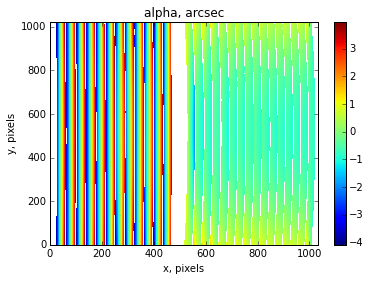

In [50]:
from IPython.html import widgets

plt.imshow(alpha, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xlabel('x, pixels')

plt.ylabel('y, pixels')
plt.title("alpha, arcsec")


<matplotlib.colorbar.Colorbar instance at 0x000000001854BCC8>

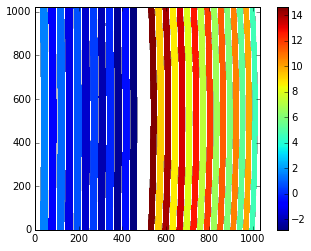

In [51]:
plt.imshow(beta)
plt.colorbar()

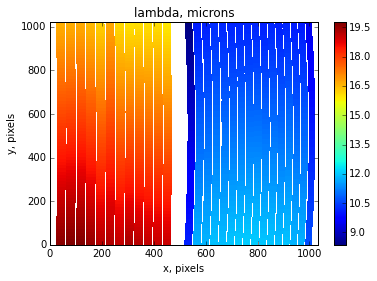

In [52]:
plt.imshow(lam, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title("lambda, microns")
plt.xlabel('x, pixels')
plt.ylabel('y, pixels')


In [53]:
# Execute the forward transforms for slice # 22

slice_22_transform = ifuwcs.forward_transform.set_input(2)
print(slice_22_transform(10, 20))

(-76.29092761249231, -2.412684, 19.112697484628328)
